In [ ]:
# Import necessary libraries
import tensorflow as tf
from tensorflow import keras
import numpy as np
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, LSTM, Reshape, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers
import matplotlib.pyplot as plt
!pip install opendatasets

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/datasets/dhruvsaluja/indian-medicinal-plants")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: dhruvsaluja
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/dhruvsaluja/indian-medicinal-plants


100%|██████████| 253M/253M [00:04<00:00, 57.2MB/s]

In [ ]:
# Define parameters
input_shape = (150, 150, 3)  # Adjust the image size as needed
batch_size = 32
epochs = 20
num_classes = 40  # Number of different plant classes
data_dir = "/content/indian-medicinal-plants/Indian Medicinal Plant Image Datasets/Medicinal plant dataset"  # Replace with the path to your dataset folder


In [ ]:
# Create a mapping between class indices and plant names
class_mapping = {
    0: 'Aloevera',
    1: 'Amla',
    2: 'Amruta Balli',
    3: 'Arali',
    4: 'Ashoka',
    5: 'Ashwagandha',
    6: 'Avacado',
    7: 'Bamboo',
    8: 'Basale',
    9: 'Betel',
    10: 'Betel_Nut',
    11: 'Brahmi',
    12: 'Castor',
    13: 'Curry Leaf',
    14: 'Doddapatre',
    15: 'Ekka',
    16: 'Ganike',
    17: 'Gauva',
    18: 'Geranium',
    19: 'Henna',
    20: 'Hibiscus',
    21: 'Honge',
    22: 'Insulin',
    23: 'Jasmine',
    24: 'Lemon',
    25: 'Lemon_grass',
    26: 'Mango',
    27: 'Mint',
    28: 'Nagadali',
    29: 'Neem',
    30: 'Nithyapushpa',
    31: 'Nooni',
    32: 'Pappaya',
    33: 'Pepper',
    34: 'Pomegranate',
    35: 'Raktachandini',
    36: 'Rose',
    37: 'Sapota',
    38: 'Tulasi',
    39: 'Wood_sorel',
    # Add mappings for all 40 classes here
}

In [ ]:
# Data preprocessing and augmentation
datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,     # Normalize pixel values
    rotation_range=20,      # Randomly rotate images
    width_shift_range=0.2,  # Randomly shift images horizontally
    height_shift_range=0.2, # Randomly shift images vertically
    shear_range=0.2,        # Shear intensity
    zoom_range=0.2,         # Randomly zoom in on images
    horizontal_flip=True,   # Randomly flip images horizontally
    fill_mode='nearest',    # Fill missing pixels with the nearest value
    validation_split=0.2     # 20% of data will be used for validation
)

In [ ]:
# Load and augment training data (80%)
train_generator = datagen.flow_from_directory(
    data_dir,                 # Root directory containing 40 subfolders
    target_size=input_shape[:2],   # Resize images to match input_shape
    batch_size=batch_size,
    class_mode='categorical',  # Categorical classification
    shuffle=True,             # Shuffle the data for training
    subset='training'         # Specify training data subset
)

Found 4765 images belonging to 40 classes.


In [ ]:
# Load and augment validation data (20%)
validation_generator = datagen.flow_from_directory(
    data_dir,                 # Root directory containing 40 subfolders
    target_size=input_shape[:2],  # Resize images to match input_shape
    batch_size=batch_size,
    class_mode='categorical',  # Categorical classification
    shuffle=False,            # Do not shuffle for validation
    subset='validation'       # Specify validation data subset
)


Found 1180 images belonging to 40 classes.


In [ ]:
# Define DenseNet feature extractor
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=input_shape)
# Unfreeze a few top layers for fine-tuning (experiment with number of layers)
for layer in base_model.layers[-30:]:  # Unfreeze the last 30 layers
    layer.trainable = True

# Feature extraction with Global Average Pooling
x = base_model.output
x = GlobalAveragePooling2D()(x)

# Reshape for LSTM input
x = Reshape((1, int(x.shape[1])))(x)

# Hyperparameter tuning for LSTM (experiment with different values)
lstm_layer = LSTM(512, return_sequences=False)(x)

# Dropout for regularization (adjust dropout rate as needed)
x = Dropout(0.3)(lstm_layer)

# Define L2 regularization with a coefficient of 0.001
l2_reg = regularizers.l2(0.01)

# Apply L2 regularization to the Dense layers
x = Dense(units=64, activation='relu', kernel_regularizer=l2_reg)(x)

# Final dense layer for classification
predictions = Dense(num_classes, activation='softmax')(x)

# Create the final hybrid model
model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
# # Load the DenseNet121 model with pretrained weights
# base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

# # Freeze the pretrained layers
# for layer in base_model.layers:
#     layer.trainable = False

# # Create a new model on top of the pretrained model
# x = base_model.output
# x = GlobalAveragePooling2D()(x)
# x = Dense(128, activation='relu', name='custom_dense')(x)  # Custom dense layer with a valid name
# predictions = Dense(num_classes, activation='softmax', name='output_layer')(x)

# # Combine the base model and the new classification layers
# model = Model(inputs=base_model.input, outputs=predictions)

In [ ]:
# # Load the DenseNet121 model with pretrained weights
# base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)

# # Freeze the pretrained layers
# for layer in base_model.layers:
#     layer.trainable = False

In [ ]:
# # Create a new model on top of the pretrained model
# model = Sequential()
# model.add(base_model)
# model.add(GlobalAveragePooling2D())
# model.add(Dense(128, activation='relu'))
# model.add(Dense(num_classes, activation='softmax'))

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_4 (InputLayer)        [(None, 150, 150, 3)]        0         []                            
                                                                                                  
 zero_padding2d_6 (ZeroPadd  (None, 156, 156, 3)          0         ['input_4[0][0]']             
 ing2D)                                                                                           
                                                                                                  
 conv1/conv (Conv2D)         (None, 75, 75, 64)           9408      ['zero_padding2d_6[0][0]']    
                                                                                                  
 conv1/bn (BatchNormalizati  (None, 75, 75, 64)           256       ['conv1/conv[0][0]']    

In [ ]:
# Define Early Stopping callback
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, mode='max', min_delta=0.01, restore_best_weights= True)


In [ ]:
# Train the model with validation data
history = model.fit(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,  # Use validation data
    # callbacks=[early_stopping]  # Add Early Stopping callback
)

Epoch 1/20
149/149 [==============================] - 61s 406ms/step - loss: 0.7682 - accuracy: 0.9824 - val_loss: 0.7766 - val_accuracy: 0.9534
Epoch 2/20
149/149 [==============================] - 60s 403ms/step - loss: 0.6631 - accuracy: 0.9824 - val_loss: 0.6486 - val_accuracy: 0.9653
Epoch 3/20
149/149 [==============================] - 61s 409ms/step - loss: 0.5704 - accuracy: 0.9822 - val_loss: 0.5652 - val_accuracy: 0.9729
Epoch 4/20
149/149 [==============================] - 61s 405ms/step - loss: 0.4888 - accuracy: 0.9838 - val_loss: 0.5333 - val_accuracy: 0.9593
Epoch 5/20
149/149 [==============================] - 60s 403ms/step - loss: 0.4251 - accuracy: 0.9885 - val_loss: 0.4865 - val_accuracy: 0.9568
Epoch 6/20
149/149 [==============================] - 61s 410ms/step - loss: 0.3685 - accuracy: 0.9901 - val_loss: 0.3922 - val_accuracy: 0.9763
Epoch 7/20
149/149 [==============================] - 61s 406ms/step - loss: 0.3125 - accuracy: 0.9935 - val_loss: 0.3644 - val_ac

In [ ]:
# Function to plot metrics
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''
    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

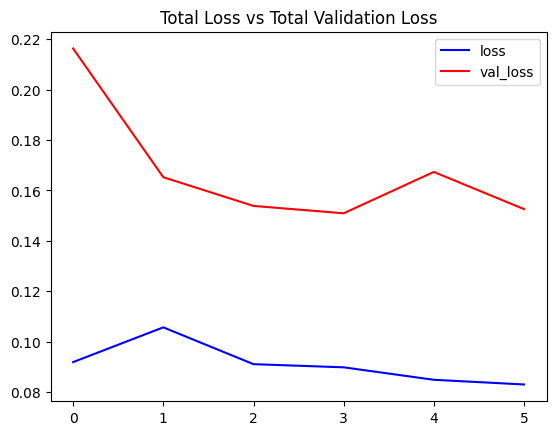

In [ ]:
# Plot metrics
plot_metric(history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')
plt.show()

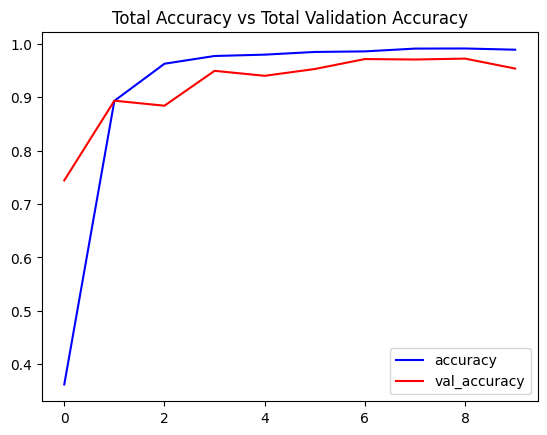

In [ ]:
plot_metric(istory, 'accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')
plt.show()

In [ ]:
# Evaluate the model on the validation set
validation_steps = len(validation_generator)
validation_generator.reset()
y_true = validation_generator.classes
y_pred_probs = model.predict(validation_generator, steps=validation_steps)
y_pred = np.argmax(y_pred_probs, axis=1)

37/37 [==============================] - 13s 243ms/step


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Calculate evaluation metrics
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Display classification report and confusion matrix
class_names = list(class_mapping.values())
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_true, y_pred)
print(conf_matrix)

Accuracy: 0.9593220338983051
Precision: 0.963450504525084
Recall: 0.9593220338983051
F1 Score: 0.9591726360461317

Classification Report:
               precision    recall  f1-score   support

     Aloevera       1.00      0.88      0.93        32
         Amla       0.97      1.00      0.98        29
 Amruta Balli       1.00      0.76      0.86        29
        Arali       1.00      1.00      1.00        29
       Ashoka       1.00      1.00      1.00        29
  Ashwagandha       1.00      0.97      0.98        29
      Avacado       1.00      1.00      1.00        29
       Bamboo       1.00      0.97      0.98        29
       Basale       1.00      0.79      0.88        29
        Betel       0.94      1.00      0.97        30
    Betel_Nut       0.97      1.00      0.98        29
       Brahmi       1.00      1.00      1.00        29
       Castor       0.91      1.00      0.96        32
   Curry Leaf       0.97      1.00      0.98        29
   Doddapatre       1.00      1.00  

In [ ]:
# Save the trained model
model.save('plant_classification_model_Hybrid.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# Load the model for inference
loaded_model = keras.models.load_model('plant_classification_model_Hybrid.h5')


In [ ]:
# Example code for prediction on a new image
def predict_plant(image_path):
    img = image.load_img(image_path, target_size=input_shape[:2])
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img /= 255.0

    prediction = loaded_model.predict(img)
    class_index = np.argmax(prediction)
    plant_name = class_mapping.get(class_index, 'Unknown Plant')
    confidence = np.max(prediction)

    return plant_name, confidence

In [ ]:
# Example usage:
image_path = '/content/test4.jpg'
predicted_plant, confidence = predict_plant(image_path)
print(f"Predicted plant: {predicted_plant}")
print(f"Confidence level: {confidence * 100:.2f}%")

1/1 [==============================] - 0s 63ms/step
Predicted plant: Hibiscus
Confidence level: 94.07%
